In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


## EDA

In [3]:
data = pd.read_csv("train.csv")
print(data.head())
print("Data shape:", data.shape)
print("Missing values:", data.isnull().sum())
print(data.describe())

                                              Quotes
0  Embrace the beauty of every sunrise; it's a fr...
1  Embrace challenges; they are the stepping ston...
2  Embrace the rhythm of life and let it dance th...
3  Embrace kindness, for it has the power to chan...
4  Embrace the journey, for it leads to the desti...
Data shape: (1000, 1)
Missing values: Quotes    0
dtype: int64
                                                   Quotes
count                                                1000
unique                                                890
top     Radiate acceptance, and find peace in embracin...
freq                                                    5


In [4]:
data = data.drop_duplicates()
data = list(data['Quotes'])

In [5]:
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(data)
tokenizer.word_index

{'the': 1,
 'of': 2,
 'your': 3,
 'and': 4,
 'a': 5,
 'is': 6,
 'in': 7,
 'for': 8,
 'let': 9,
 'to': 10,
 'it': 11,
 'be': 12,
 'every': 13,
 'our': 14,
 'you': 15,
 'that': 16,
 'embrace': 17,
 "life's": 18,
 'this': 19,
 'are': 20,
 'morning': 21,
 'with': 22,
 'radiate': 23,
 'dance': 24,
 'heart': 25,
 'believe': 26,
 'yourself': 27,
 'through': 28,
 "planet's": 29,
 'will': 30,
 'life': 31,
 'love': 32,
 'they': 33,
 "singapore's": 34,
 'kindness': 35,
 'power': 36,
 'from': 37,
 'dreams': 38,
 'we': 39,
 'soul': 40,
 'symphony': 41,
 'act': 42,
 'find': 43,
 'gratitude': 44,
 'singapore': 45,
 'world': 46,
 'strength': 47,
 'light': 48,
 'beauty': 49,
 'journey': 50,
 'nature': 51,
 'joy': 52,
 'planet': 53,
 'canvas': 54,
 'colors': 55,
 'way': 56,
 'whispers': 57,
 'where': 58,
 'potential': 59,
 'hope': 60,
 'testament': 61,
 'resilience': 62,
 'towards': 63,
 'true': 64,
 'new': 65,
 'compassion': 66,
 'beacon': 67,
 'actions': 68,
 'future': 69,
 'spirit': 70,
 'step': 71,


In [6]:
print(data[0])
print(tokenizer.texts_to_sequences([data[1]]))

Embrace the beauty of every sunrise; it's a fresh chance to paint your world with joy.
[[17, 148, 33, 20, 1, 373, 487, 10, 3, 374, 687]]


In [7]:
sequences = tokenizer.texts_to_sequences(data)
padded_sequences = pad_sequences(sequences, padding="pre")

In [8]:
print(len(padded_sequences[0]))

35


In [9]:
word_freq = tokenizer.word_counts
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
print(sorted_word_freq[:10])

num_unique_words = len(tokenizer.word_index)
print(f"There are {num_unique_words} unique words.")

[('the', 869), ('of', 663), ('your', 350), ('and', 322), ('a', 307), ('is', 253), ('in', 249), ('for', 201), ('let', 187), ('to', 180)]
There are 1198 unique words.


There's 890 Quotes and 1198 Unique Words. In those 890 quotes we have 869 'the' and 663 'of' it's very likely that the model we build will often predict those 2 phrases very often.

### How to deal with 'the' and 'of'
We can create new data, that is less biased towards the 'the' and 'of'.  
Slice the quotes into different sizes and then train the model on that

In [10]:
# Split the data into 2, 3 words
phrases = []
for quote in sequences:
    for i in range(len(quote) - 1):
        phrases.append(quote[i : i + 2])  # create 2-word phrases
    for i in range(len(quote) - 2):
        phrases.append(quote[i : i + 3])  # create 3-word phrases

total_data = phrases + sequences

# pad the sequences
max_sequence_len = max([len(x) for x in total_data])
padded_sequences = pad_sequences(total_data, maxlen=max_sequence_len, padding="pre")

In [11]:
# Split the data into X and Y
X = padded_sequences[:, :-1]
labels = padded_sequences[:, -1]

In [12]:
labels_encoded = tf.keras.utils.to_categorical(labels, num_classes=num_unique_words + 1)
print(X.shape)
print(labels_encoded.shape)

(19458, 34)
(19458, 1199)


### Train the inital model

In [13]:
vocab_size = len(tokenizer.word_index) + 1


def first_model():
    model = Sequential()
    model.add(Embedding(vocab_size, 50, input_length=max_sequence_len - 1))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dense(vocab_size, activation="softmax"))
    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return model


model = first_model()
history = model.fit(
    X,
    labels_encoded,
    batch_size=128,
    epochs=100,
    verbose=1,
    shuffle=True,
    callbacks=[keras.callbacks.EarlyStopping(monitor="loss", patience=3),
               keras.callbacks.ModelCheckpoint(filepath="base_model_rnn.h5", monitor="loss", save_best_only=True)]
)

Epoch 1/100
153/153 [==============================] - 7s 6ms/step - loss: 5.6790 - accuracy: 0.0678
Epoch 2/100
153/153 [==============================] - 1s 6ms/step - loss: 5.1801 - accuracy: 0.0895
Epoch 3/100
153/153 [==============================] - 1s 6ms/step - loss: 4.9896 - accuracy: 0.1150
Epoch 4/100
153/153 [==============================] - 1s 6ms/step - loss: 4.7597 - accuracy: 0.1490
Epoch 5/100
153/153 [==============================] - 1s 6ms/step - loss: 4.4988 - accuracy: 0.1811
Epoch 6/100
153/153 [==============================] - 1s 6ms/step - loss: 4.2691 - accuracy: 0.2340
Epoch 7/100
153/153 [==============================] - 1s 6ms/step - loss: 4.0762 - accuracy: 0.2563
Epoch 8/100
153/153 [==============================] - 1s 6ms/step - loss: 3.9110 - accuracy: 0.2793
Epoch 9/100
153/153 [==============================] - 1s 6ms/step - loss: 3.7664 - accuracy: 0.2990
Epoch 10/100
153/153 [==============================] - 1s 6ms/step - loss: 3.6371 - accura

In [14]:
def tune_model_layers(number_layers):
    model = Sequential()
    
    model.add(Embedding(vocab_size, 50, input_length=max_sequence_len - 1))
    for i in range(number_layers):
        model.add(LSTM(100, return_sequences=True))
        model.add(tf.keras.layers.LayerNormalization())

    model.add(LSTM(100, return_sequences=False))
    model.add(tf.keras.layers.LayerNormalization())
    model.add(Dense(vocab_size, activation="softmax"))
    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    
    history = model.fit(
        X,
        labels_encoded,
        batch_size=64,
        epochs=100,
        verbose=1,
        shuffle=True,
    )
    return history

Epoch 1/100
305/305 [==============================] - 3s 6ms/step - loss: 5.2673 - accuracy: 0.1367
Epoch 2/100
305/305 [==============================] - 2s 6ms/step - loss: 3.6396 - accuracy: 0.3380
Epoch 3/100
305/305 [==============================] - 2s 6ms/step - loss: 2.9070 - accuracy: 0.4056
Epoch 4/100
305/305 [==============================] - 2s 6ms/step - loss: 2.5248 - accuracy: 0.4371
Epoch 5/100
305/305 [==============================] - 2s 6ms/step - loss: 2.2933 - accuracy: 0.4636
Epoch 6/100
305/305 [==============================] - 2s 6ms/step - loss: 2.1504 - accuracy: 0.4787
Epoch 7/100
305/305 [==============================] - 2s 6ms/step - loss: 2.0497 - accuracy: 0.4929
Epoch 8/100
305/305 [==============================] - 2s 6ms/step - loss: 1.9781 - accuracy: 0.5016
Epoch 9/100
305/305 [==============================] - 2s 6ms/step - loss: 1.9294 - accuracy: 0.5064
Epoch 10/100
305/305 [==============================] - 2s 6ms/step - loss: 1.8877 - accura

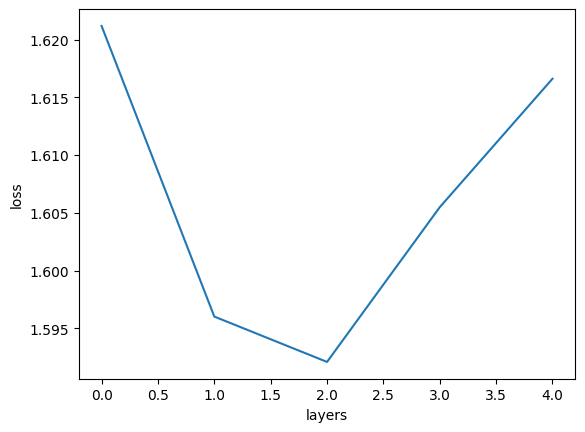

In [22]:
results = []
for i in range(0, 5):
    history_layers = tune_model_layers(i)
    results.append({
            "layers": i,
            "loss": min(history_layers.history["loss"]),
            "accuracy": max(history_layers.history["accuracy"]),
        })
    
results_layers = pd.DataFrame(results)
sns.lineplot(x="layers", y="loss", data=results_layers)
plt.show()

In [16]:
def tune_model_LSTM(lstm_size):
    model = Sequential()
    model.add(Embedding(vocab_size, 50, input_length=max_sequence_len - 1))
    for i in range(1):
        model.add(LSTM(lstm_size, return_sequences=True))
        model.add(tf.keras.layers.LayerNormalization())
        
    model.add(LSTM(lstm_size, return_sequences=False))
    model.add(tf.keras.layers.LayerNormalization())
    model.add(Dense(vocab_size, activation="softmax"))
    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    
    history = model.fit(
        X,
        labels_encoded,
        batch_size=64,
        epochs=100,
        verbose=1,
        shuffle=True,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor="loss", patience=10, min_delta=0.0001, restore_best_weights=True
            )
        ],
    )
    return history


In [18]:
results = []
for i in range(30,120,10):
    history_layers = tune_model_LSTM(i)
    results.append({
            "units": i,
            "loss": min(history_layers.history["loss"]),
            "accuracy": max(history_layers.history["accuracy"]),
        })
results_units = pd.DataFrame(results)

Epoch 1/100
305/305 [==============================] - 5s 10ms/step - loss: 5.5212 - accuracy: 0.1132
Epoch 2/100
305/305 [==============================] - 3s 9ms/step - loss: 4.1534 - accuracy: 0.2891
Epoch 3/100
305/305 [==============================] - 3s 9ms/step - loss: 3.4031 - accuracy: 0.3695
Epoch 4/100
305/305 [==============================] - 3s 9ms/step - loss: 3.0031 - accuracy: 0.4013
Epoch 5/100
305/305 [==============================] - 3s 9ms/step - loss: 2.7306 - accuracy: 0.4329
Epoch 6/100
305/305 [==============================] - 3s 10ms/step - loss: 2.5309 - accuracy: 0.4498
Epoch 7/100
305/305 [==============================] - 3s 10ms/step - loss: 2.3781 - accuracy: 0.4654
Epoch 8/100
305/305 [==============================] - 3s 10ms/step - loss: 2.2644 - accuracy: 0.4745
Epoch 9/100
305/305 [==============================] - 3s 10ms/step - loss: 2.1696 - accuracy: 0.4844
Epoch 10/100
305/305 [==============================] - 3s 10ms/step - loss: 2.0976 - 

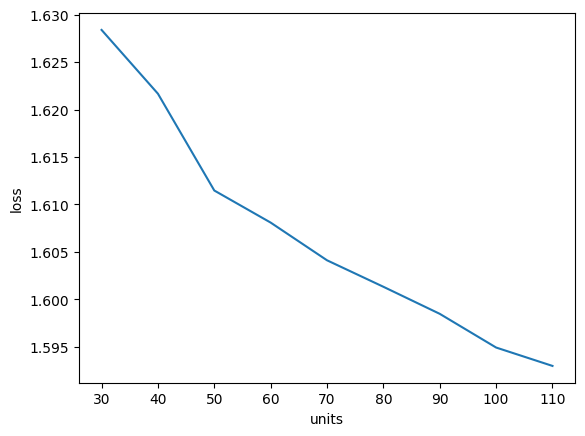

In [21]:
sns.lineplot(x='units', y="loss", data=results_units)
plt.show()

In [ ]:
stop

In [ ]:
def final_model():
    model = Sequential()
    model.add(Embedding(vocab_size, 50, input_length=max_sequence_len - 1))
    for i in range(1):
        model.add(LSTM(100, return_sequences=True))
        model.add(tf.keras.layers.LayerNormalization())
        
    model.add(LSTM(100, return_sequences=False))
    model.add(tf.keras.layers.LayerNormalization())
    model.add(Dense(vocab_size, activation="softmax"))
    model.compile(
        loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return model

In [ ]:
final_model = final_model()
final_model.fit(
    X,
    labels_encoded,
    batch_size=64,
    epochs=50,
    verbose=1,
    shuffle=True,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10, min_delta=0.0001, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("final_model.h5", monitor="loss", save_best_only=True, verbose=1)
    ]
)

In [ ]:
def predict_next_N_words_unique(seed_texts, top_p=1, N_words=10):
    generated_texts = []

    for seed_text in seed_texts:
        current_generated_text = seed_text
        for i in range(N_words):
            seed_sequence = tokenizer.texts_to_sequences([seed_text])[0]
            padded_sequence = tf.keras.preprocessing.sequence.pad_sequences([seed_sequence], maxlen=max_sequence_len - 1)
            predictions = final_model.predict(padded_sequence, verbose=0)[0]

            sorted_indices = np.argsort(predictions)[::-1]
            cumulative_probs = np.cumsum(predictions[sorted_indices])
            selected_indices = sorted_indices[cumulative_probs <= top_p]

            selected_probs = predictions[selected_indices] / np.sum(
                predictions[selected_indices]
            )

            next_index = np.random.choice(selected_indices, p=selected_probs)
            next_word = tokenizer.index_word[next_index]

            if (
                next_word is None
                or next_word == "end_token"
                or len(current_generated_text.split()) >= N_words + len(seed_text)
            ):
                break

            current_generated_text += " " + next_word
            seed_text += " " + next_word

        generated_texts.append(current_generated_text)
    return generated_texts

In [ ]:
seed_texts = [
    "embrace each day",
    "radiate some",
    "believe that",
    "life's actual purpose is",
    "dance through each and every",
    "let your time and energy",
    "every person is",
    "our country Singapore is",
    "planet earth is",
    "morning and evening would make it",
]

In [ ]:
predicted_texts = predict_next_N_words_unique(seed_texts)